# Physics Informed Neural Network

## Libraries

In [45]:
import torch
import scipy
import numpy as np
import matplotlib.pyplot as plt

## Import Data
- Extract the initial condition
- The rest of data is used to compare with predicted solutions of NN.

In [46]:
data_dir_phi = 'D:/Users/Roberth/Desktop/2D_Pinns/Data/LSM_data/LSM_1256x1x64x64.mat'
data_dir_uv = 'D:/Users/Roberth/Desktop/2D_Pinns/Data/LSM_data/UV_1256x2x64x64.mat'

In [47]:
data_phi = scipy.io.loadmat(data_dir_phi)
data_uv = scipy.io.loadmat(data_dir_uv) 
phi = data_phi['phi']
uv = data_uv['uv']

## Initial Condition 
- Transform IC to tensor using torch.tensor
- Graph IC and vector field

In [48]:
phi_0 = torch.tensor(phi[0:1, ...], dtype=torch.float32)
phi_0.shape

torch.Size([1, 1, 64, 64])

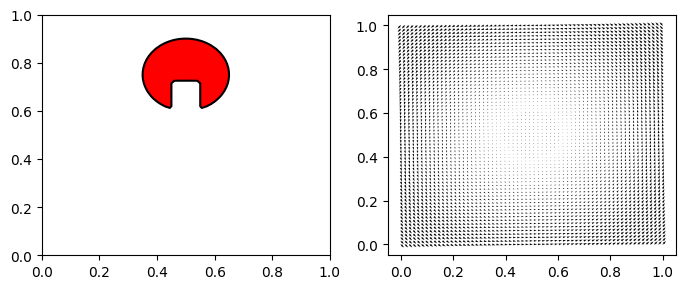

In [49]:
# Grid 
x_min = 0
x_max = 1
y_min = 0
y_max = 1
nodes = 64
x = np.linspace(x_min, x_max, nodes)
y = np.linspace(y_min, y_max, nodes)
X, Y = np.meshgrid(x, y, indexing='ij')

# Subplots 
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

axs[0].contourf(X, Y, phi[0, 0, :, :], levels=[-1e6, 0], colors='red')
axs[0].contour(X, Y, phi[0, 0, :, :], levels=[0], colors='black')

axs[1].quiver(X, Y, uv[0, 0, :, :], uv[0, 1, :, :])
plt.tight_layout()

plt.show()

## Set initial states for convlstm
- h0 the initial hidden state of the LSTM: short term memory
- c0 the state of the initial cell of the LSTM: long term memory
- Initialize using normal distribution: $$h_{0}, c_{0} \sim \mathcal{N}(0, 1)$$
- Initialize using zeros.

In [50]:
num_convlstm = 1
(h0, c0) = (torch.randn(1, 64, 8, 8), torch.randn(1, 64, 8, 8))
initial_state = [] #lista
for i in range(num_convlstm):
    initial_state.append((h0, c0))

## Parameters of time steps

In [51]:
time_steps = 100
dt = 0.5 # In each dt, the neural network predicts a solution
dx = (x_max - x_min) / nodes

## Parameters to train PhyCRNet
- Define parameters
- Convert u and v to tensors

In [52]:
time_batch_size = 99
steps = time_batch_size + 1
effective_step = list(range(0, steps))
num_time_batch = int(time_steps / time_batch_size)
n_iters_adam = 2000
lr_adam = 1e-4
# Vector field to tensors
u_t = torch.tensor(uv[0:time_batch_size, 0:1, :, :])
v_t = torch.tensor(uv[0:time_batch_size, 1:2, :, :])
v_t.shape

torch.Size([99, 1, 64, 64])

## Path directories to save and load weigths of model 

In [53]:
model_save_path = 'D:/Users/Roberth/Desktop/2D_Pinns/Weights/3_train/parameters.pt'
pre_model_save_path = 'D:/Users/Roberth/Desktop/2D_Pinns/Weights/3_train/parameters.pt'
fig_save_path = 'D:/Users/Roberth/Desktop/2D_Pinns/img/'

## Build model: PhyCRNet
### Parameters of model
- input_channels
- hidden_channels
- input_kernel_size
- input_stride
- input_padding
- dt
- num_layers
- upscale_factor
- step
- ef_step

In [54]:
import sys 
sys.path.append('D:/Users/Roberth/Desktop/2D_Pinns')
from PhyCRNet_Lsm import PhyCRNetLSM
import PhyCRNet_Lsm as phyL

In [55]:
model = PhyCRNetLSM(
    input_channels=1,
    hidden_channels=[8, 32, 64, 64],
    input_kernel_size=[4, 4, 4, 3],
    input_stride=[2, 2, 2, 1],
    input_padding=[1, 1, 1, 1],
    dt=dt,
    num_layers=[3, 1],
    upscale_factor=8,
    step=steps,
    ef_step=effective_step  
)

## Train Model to predict solutions of Level Set Equation
$$\phi_{t} + u\cdot\phi_{x} + v\cdot\phi_{y}=0, \quad t>0,\quad x, y \in [0, 1] \times [0, 1]$$
### Parameters
- model
- input:
  $$\phi_{0}$$
- initial_state (list):
  $$h_{0}, c_{0}$$
- n_iters_adam
- time_batch_size (Delete)
- lr_adam
- dt
- dx
- model_save_path
- pre_model_save_path (If there is a saved weights)
- num_time_batch
- tensors of components of vector field (u, v)
## Called train function to star 
```python
start = time.time()
train_loss = train(model, inp, initial_state, n_iters_adam, time_batch_size,
                   lr_adam, dt, dx, model_save_path, pre_model_save_path, num_time_batch, u, v)
end = time.time()
```

## Model Training

## Model Inference

In [56]:
## Parameters
time_steps_load = 100
time_batch_load = 99
steps_load = time_batch_load + 1
num_time_batch_load = int(time_steps_load / time_batch_load)
effective_step_load = list(range(0, steps_load))

In [57]:
model_inference = PhyCRNetLSM(
    input_channels = 1,
    hidden_channels = [8, 32, 64, 64],
    input_kernel_size = [4, 4, 4, 3],
    input_stride = [2, 2, 2, 1],
    input_padding = [1, 1, 1, 1],
    dt = dt,
    num_layers = [3, 1],
    upscale_factor = 8,
    step = steps_load,
    ef_step = effective_step_load
)

In [ ]:
def post_process(out, true, phi0, axis_lim, phi_lim, num, nodes, save_dir):
    x_min, x_max, y_min, y_max = axis_lim
    # grid 
    x = np.linspace(x_min, x_max, nodes)
    y = np.linspace(y_min, y_max, nodes)
    X, Y = np.meshgrid(X, Y, indexing='ij')
    # Tranform tensor to array
    output = torch.cat(tuple(out), dim=0)
    output = torch.cat((phi0, output), dim=0)
    phi_pred = output[:, 0, :, :].detach().cpu().numpy()
    
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize(4, 4))
    axs[0, 0].contourf(X, Y, true[0, 0, :, :], levels=[-1e6, 0], colors='red')
    axs[0, 0].contourf(X, Y, true[0, 0, :, :], levels=[0], colors='black')
    axs[0, 0].set_title('t=0, Numerical Method')

    axs[0, 1].contourf(X, Y, phi_pred[0, :, :], levels=[-1e6, 0], colors='red')
    axs[0, 1].contourf(X, Y, phi_pred[0, :, :], levels=[0], colors='black')
    axs[0, 1].set_title('t=0, PhyCRNet')

    axs[1, 0].contourf(X, Y, true[50, 0, :, :], levels=[-1e6, 0], colors='red')
    axs[1, 0].contourf(X, Y, true[50 0, :, :], levels=[0], colors='black')
    axs[1, 0].set_title('t=50, Numerical Method')

    axs[1, 1].contourf(X, Y, phi_pred[50, :, :], levels=[-1e6, 0], colors='red')
    axs[1, 1].contourf(X, Y, phi_pred[50, :, :], levels=[0], colors='black')
    axs[1, 1].set_title('t=50, PhyCRNet')

    axs[2, 0].contourf(X, Y, true[99, 0, :, :], levels=[-1e6, 0], colors='red')
    axs[2, 0].contourf(X, Y, true[99, 0, :, :], levels=[0], colors='black')
    axs[2, 0].set_title('t=99, Numerical Method')

    axs[2, 1].contourf(X, Y, phi_pred[99, :, :], levels=[-1e6, 0], colors='red')
    axs[2, 1].contourf(X, Y, phi_pred[99, :, :], levels=[0], colors='black')
    axs[2, 1].set_title('t=99, PhyCRNet')
    
    
    

In [ ]:
model_inference, _, _ = phyL.load_checkpoint(model_inference, optimizer=None, scheduler=None, save_dir=pre_model_save_path)
output, _ = model_inference(initial_state, phi_0)

## Train loss

In [58]:
path_train = 'D:/Users/Roberth/Desktop/2D_Pinns/Weights/2_train/train_loss2.npy'

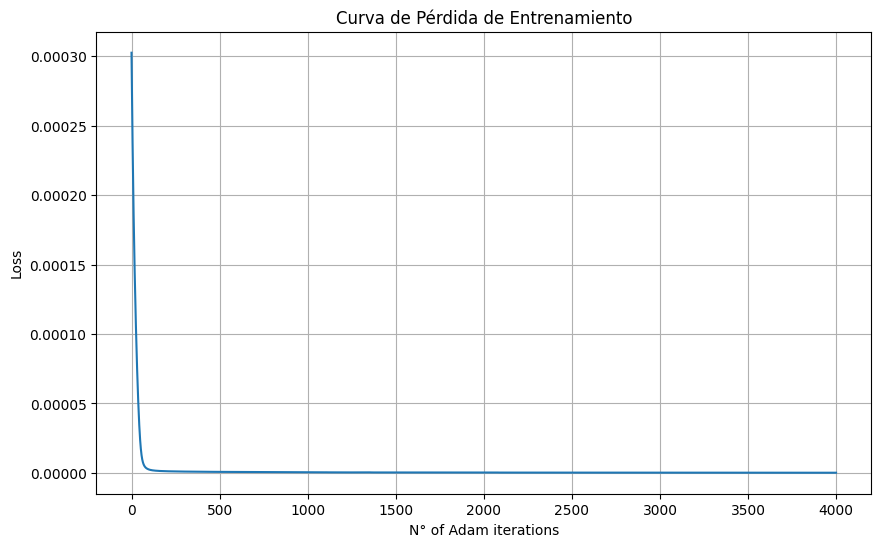

In [59]:
train_loss = np.load(path_train)
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Pérdida de Entrenamiento')
plt.title('Curva de Pérdida de Entrenamiento')
plt.xlabel('N° of Adam iterations') 
plt.ylabel('Loss')
plt.grid(True) 